RUN IN KAGGLE


In [1]:
!pip install pycocotools
!pip install ultralytics
!pip install jq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 5.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 876.2/876.2 kB 13.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 kB 10.3 MB/s eta 0:00:0000:010:01


optimizer:  Choice of optimizer for training. Options include SGD, Adam, AdamW, NAdam, RAdam, RMSProp etc., or auto for automatic selection based on model configuration. Affects convergence speed and stability.



In [3]:
from ultralytics import YOLO
import os
import torch
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
import requests
import zipfile
import os
from pycocotools.coco import COCO
import numpy as np
import torch.nn as nn
import subprocess

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
# Change datasets_dir, since default kaggle/working/datasets is only 20gb, 40gb is needed
command = """jq '.datasets_dir = "/content/datasets"' /root/.config/Ultralytics/settings.json > /root/.config/Ultralytics/temp.json && mv /root/.config/Ultralytics/temp.json /root/.config/Ultralytics/settings.json"""

subprocess.run(command, shell=True)

CompletedProcess(args='jq \'.datasets_dir = "/content/datasets"\' /root/.config/Ultralytics/settings.json > /root/.config/Ultralytics/temp.json && mv /root/.config/Ultralytics/temp.json /root/.config/Ultralytics/settings.json', returncode=0)

In [5]:
# Downloading dataset. Wait 14 minutes. Look at hdd usage to see progress (not output)
# After download, ensure that there are no corrupt images

# Function to download and extract dataset without logs
def download_and_extract_wget(url, save_path, extract_path):
    # Download the file without printing logs
    subprocess.run(f"wget -O {save_path} {url} > /dev/null 2>&1", shell=True)
    print(f"Download complete: {save_path}")

    # Extract the zip file
    print(f"Extracting {save_path}...")
    with zipfile.ZipFile(save_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Extraction complete: {extract_path}")

    # Remove the zip file to save space
    os.remove(save_path)
    print(f"Removed zip file: {save_path}")

# Paths for saving the datasets
base_path = '/content/datasets' #path for kaggle
os.makedirs(base_path, exist_ok=True)

# URLs for COCO 2017 dataset
urls = {
    "train_images": "http://images.cocodataset.org/zips/train2017.zip",
    "val_images": "http://images.cocodataset.org/zips/val2017.zip",
    "annotations": "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
}

# Paths to save files
train_images_path = os.path.join(base_path, "train2017.zip")
val_images_path = os.path.join(base_path, "val2017.zip")
annotations_path = os.path.join(base_path, "annotations_trainval2017.zip")

# Download and extract train images, validation images, and annotations using wget
download_and_extract_wget(urls["train_images"], train_images_path, base_path)
download_and_extract_wget(urls["val_images"], val_images_path, base_path)
download_and_extract_wget(urls["annotations"], annotations_path, base_path)

Download complete: /content/datasets/train2017.zip
Extracting /content/datasets/train2017.zip...
Extraction complete: /content/datasets
Removed zip file: /content/datasets/train2017.zip
Download complete: /content/datasets/val2017.zip
Extracting /content/datasets/val2017.zip...
Extraction complete: /content/datasets
Removed zip file: /content/datasets/val2017.zip
Download complete: /content/datasets/annotations_trainval2017.zip
Extracting /content/datasets/annotations_trainval2017.zip...
Extraction complete: /content/datasets
Removed zip file: /content/datasets/annotations_trainval2017.zip


In [6]:
model = YOLO('yolov8n.pt')
int_to_class=model.names

coco = COCO('/content/datasets/annotations/instances_train2017.json')
categories = coco.loadCats(coco.getCatIds())
cat_id_to_name = {cat['id']: cat['name'] for cat in categories}

print(cat_id_to_name)
print(int_to_class)

100%|██████████| 6.25M/6.25M [00:00<00:00, 76.0MB/s]


loading annotations into memory...
Done (t=20.99s)
creating index...
index created!
{1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light', 11: 'fire hydrant', 13: 'stop sign', 14: 'parking meter', 15: 'bench', 16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow', 22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 27: 'backpack', 28: 'umbrella', 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee', 35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite', 39: 'baseball bat', 40: 'baseball glove', 41: 'skateboard', 42: 'surfboard', 43: 'tennis racket', 44: 'bottle', 46: 'wine glass', 47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon', 51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'orange', 56: 'broccoli', 57: 'carrot', 58: 'hot dog', 59: 'pizza', 60: 'donut', 61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted plant', 65: 'bed', 67: 'dining table', 70: 'toilet', 72: 'tv', 7

In [7]:
transform = transforms.Compose([
    transforms.Resize((640, 640)),  # Resize to the input size expected by YOLO
    transforms.ToTensor()
])

coco_train = CocoDetection(
    root='/content/datasets/train2017',
    annFile='/content/datasets/annotations/instances_train2017.json',
    transform=transform
)

def collate_fn(batch):
    images, targets = zip(*batch)
    # Stack images into a batch
    images = torch.stack([torch.nn.functional.pad(img, (0, 0, 0, 0), value=0) for img in images])
    return images, targets

train_loader = DataLoader(coco_train, batch_size=4, num_workers=4, collate_fn=collate_fn)

loading annotations into memory...
Done (t=21.29s)
creating index...
index created!


In [8]:
print(len(train_loader))

29572


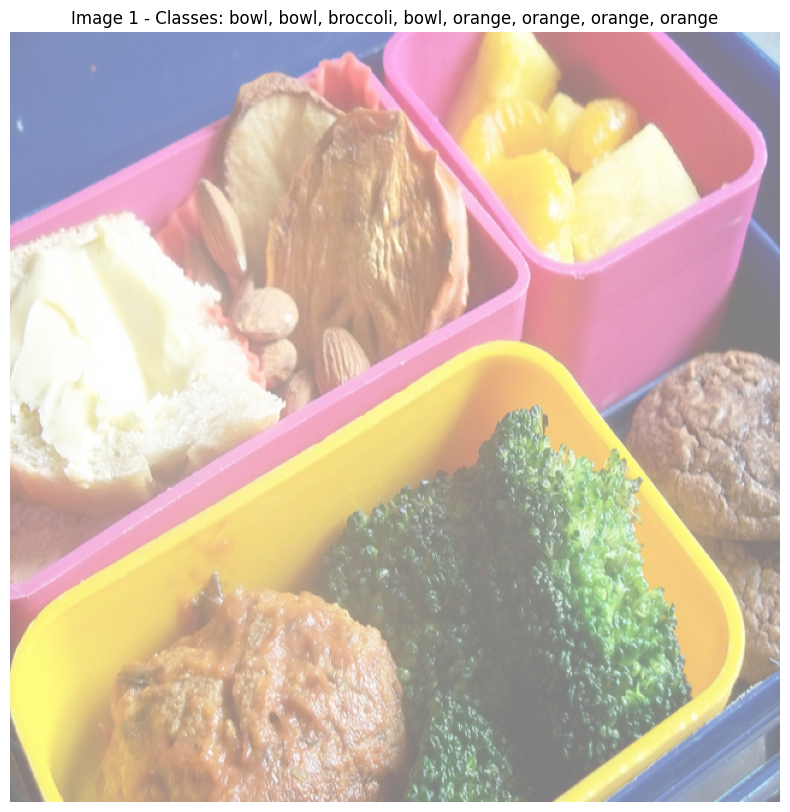

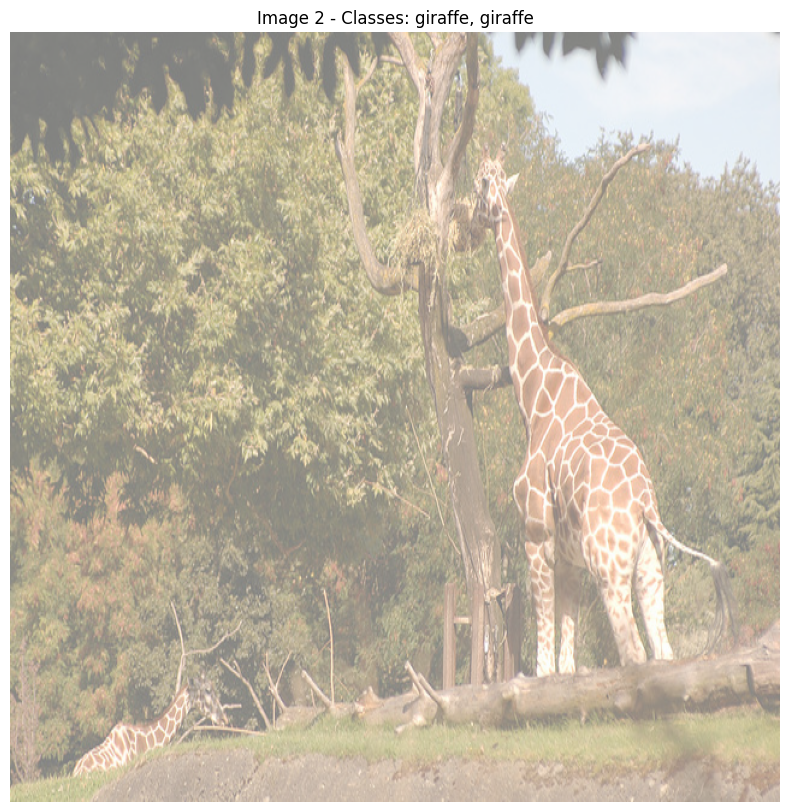

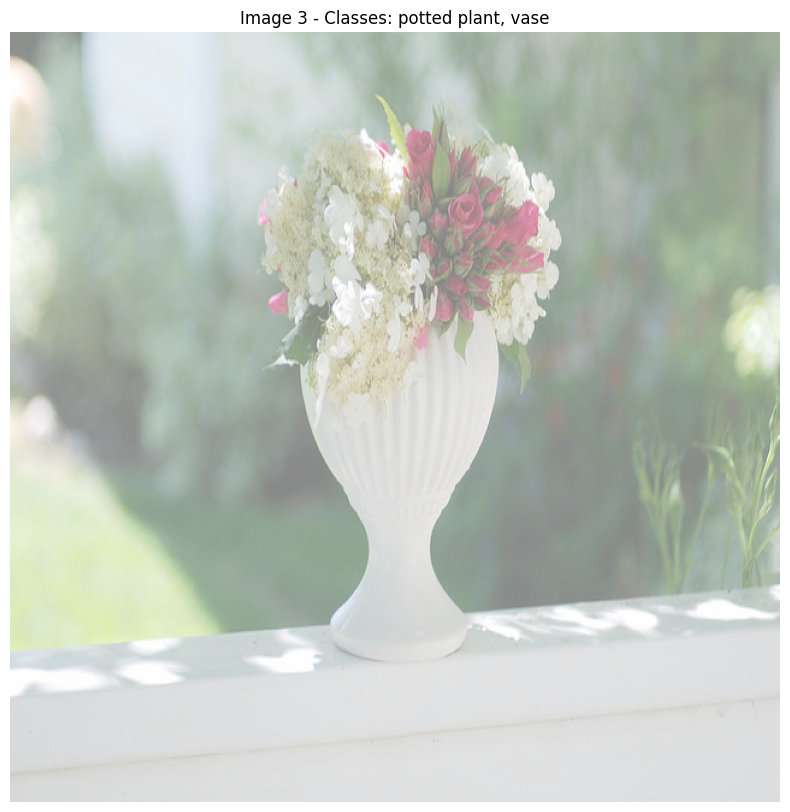

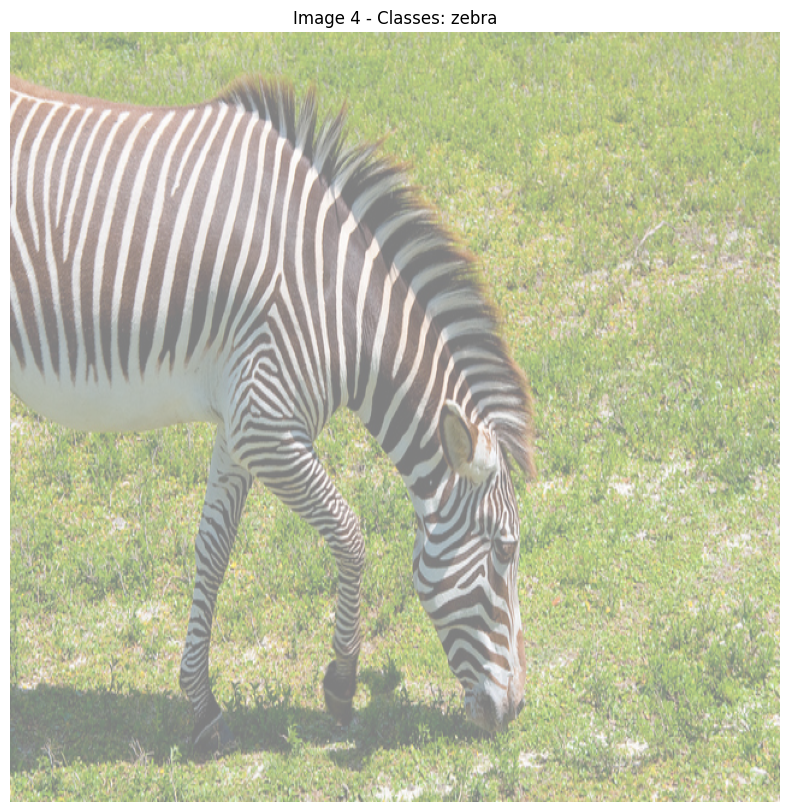

In [9]:
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
images, targets = next(iter(train_loader))

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

for i in range(4):
    plt.figure(figsize=(10, 10))
    # Extract category ids for each object in the image and map to class names
    labels = targets[i]
    class_names = [cat_id_to_name[obj['category_id']] for obj in labels]

    # Set title as class names
    plt.title(f'Image {i+1} - Classes: {", ".join(class_names)}')
    imshow(images[i])

In [10]:
# class YOLOLoss(nn.Module):
#     def __init__(self, lambda_box=5.0, lambda_obj=1.0, lambda_noobj=0.5, lambda_class=1.0):
#         super(YOLOLoss, self).__init__()
#         self.mse_loss = nn.MSELoss()  # For bounding box regression
#         self.bce_loss = nn.BCELoss()  # For objectness score (binary classification)
#         self.ce_loss = nn.CrossEntropyLoss()  # For class prediction
#         self.lambda_box = lambda_box  # Weight for bounding box loss
#         self.lambda_obj = lambda_obj  # Weight for objectness loss
#         self.lambda_noobj = lambda_noobj  # Weight for no-object loss
#         self.lambda_class = lambda_class  # Weight for class prediction loss

#     def forward(self, predictions, targets):
#         # predictions is a list of tensors from different feature scales (e.g., 80x80, 40x40, 20x20)
#         total_loss = 0.0

#         # Loop through each scale of predictions
#         for i, prediction in enumerate(predictions):
#             # Ensure the predictions and targets are tensors
#             if isinstance(prediction, list):
#                 prediction = torch.stack(prediction)
#             if isinstance(targets, list):
#                 targets = torch.stack(targets)

#             # Extract components from predictions for this scale
#             pred_boxes = prediction[..., 0:4]  # Bounding boxes (x, y, w, h)
#             pred_obj_conf = prediction[..., 4]  # Object confidence
#             pred_class_probs = prediction[..., 5:]  # Class probabilities

#             # Extract ground truth values
#             target_boxes = targets[..., 0:4]  # Ground truth bounding boxes
#             target_obj_conf = targets[..., 4]  # Ground truth object confidence
#             target_classes = targets[..., 5:]  # Ground truth class probabilities (one-hot encoded)

#             # Calculate bounding box loss (MSE)
#             box_loss = self.mse_loss(pred_boxes, target_boxes)

#             # Calculate objectness loss (BCE)
#             obj_loss = self.bce_loss(pred_obj_conf, target_obj_conf)

#             # No-object loss for regions without objects
#             noobj_loss = self.bce_loss(pred_obj_conf, torch.zeros_like(target_obj_conf))

#             # Class prediction loss (CrossEntropy)
#             class_loss = self.ce_loss(pred_class_probs, target_classes.argmax(dim=-1))

#             # Total loss for this scale
#             scale_loss = (
#                 self.lambda_box * box_loss +
#                 self.lambda_obj * obj_loss +
#                 self.lambda_noobj * noobj_loss +
#                 self.lambda_class * class_loss
#             )

#             # Accumulate loss for all scales
#             total_loss += scale_loss

#         return total_loss


In [12]:
from ultralytics.utils.loss import v8DetectionLoss

optimizers=['Adam','SGD','AdamW']
epochs = 5
model_dir = 'models'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for optimizer in optimizers:
    model = YOLO("/kaggle/input/cocoyolo_withoutcoco/other/default/1/model.yaml")
    project='./'+optimizer
    name=''
    #kaggle multiple gpus
    results = model.train(data="/kaggle/input/cocoyolo_withoutcoco/other/default/1/coco.yaml", epochs=epochs, batch=16, imgsz=640, save=True, save_period=1, device=0, optimizer=optimizer, plots=True)

WARNING ⚠️ no model scale passed. Assuming scale='n'.
Ultralytics 8.3.16 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/input/cocoyolo_withoutcoco/other/default/1/model.yaml, data=/kaggle/input/cocoyolo_withoutcoco/other/default/1/coco.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=1, cache=False, device=0, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=No

train: Scanning /content/datasets/train2017.cache... 0 images, 118287 backgrounds, 0 corrupt: 100%|██████████| 118287/118287 [00:00<?, ?it/s]


WARNING ⚠️ No labels found in /content/datasets/train2017.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/datasets/val2017.cache... 0 images, 5000 backgrounds, 0 corrupt: 100%|██████████| 5000/5000 [00:00<?, ?it/s]

WARNING ⚠️ No labels found in /content/datasets/val2017.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.


Plotting labels to runs/detect/train2/labels.jpg... 
zero-size array to reduction operation maximum which has no identity
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 63 weight(decay=0.0), 70 weight(decay=0.0005), 69 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train2
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      3.85G          0     0.3877          0          0        640: 100%|██████████| 7393/7393 [21:06<00:00,  5.84it/s]  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.36it/s]


RuntimeError: torch.cat(): expected a non-empty list of Tensors